In [1]:
import cirq

In [2]:
# Create a simple circuit
qubits = [cirq.GridQubit(0, i) for i in range(3)]

# Create a circuit
circuit = cirq.Circuit(
    cirq.H(qubits[0]),                 # Apply Hadamard gate to qubit 0
    cirq.CX(qubits[1], qubits[2]),     # Apply CNOT gate to qubits 0 and 1
    cirq.X(qubits[2]),                 # Apply X gate to qubit 2
    cirq.CX(qubits[1], qubits[0]),
    cirq.measure(*qubits, key='result123')  # Measure all qubits
)
# General purpose quantum circuit simulator
simulator = cirq.Simulator()

# Simulate the circuit using the general purpose simulator
result = simulator.simulate(circuit)
print("Result with cirq.Simulator:", result)


Result with cirq.Simulator: measurements: result123=001

qubits: (cirq.GridQubit(0, 0),)
output vector: |0⟩

qubits: (cirq.GridQubit(0, 1),)
output vector: |0⟩

qubits: (cirq.GridQubit(0, 2),)
output vector: |1⟩

phase:
output vector: |⟩


In [3]:
print(circuit)

(0, 0): ───H───X───M('result123')───
               │   │
(0, 1): ───@───@───M────────────────
           │       │
(0, 2): ───X───X───M────────────────


In [4]:
depth = len(cirq.Circuit(circuit.all_operations()))
print(depth)

3


In [5]:
x=circuit.all_qubits()

In [6]:
print(x)

frozenset({cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 0)})


In [7]:
x=circuit.all_operations()
print(x)

<generator object AbstractCircuit.all_operations.<locals>.<genexpr> at 0x76a34b9a8a50>


In [8]:
a=dict()
for i in x:
    print(i.gate)
    a[i.gate]=i.gate.num_qubits()
    print(i)

H
H(q(0, 0))
CNOT
CNOT(q(0, 1), q(0, 2))
X
X(q(0, 2))
CNOT
CNOT(q(0, 1), q(0, 0))
cirq.MeasurementGate(3, cirq.MeasurementKey(name='result123'), ())
cirq.MeasurementGate(3, cirq.MeasurementKey(name='result123'), ())(q(0, 0), q(0, 1), q(0, 2))


In [9]:
print(a)

{cirq.H: 1, cirq.CNOT: 2, cirq.X: 1, cirq.MeasurementGate(3, cirq.MeasurementKey(name='result123'), ()): 3}


In [10]:
from collections import Counter

# Function to count the operations in the circuit
def count_operations(circuit):
    operation_counter = Counter()
    for op in circuit.all_operations():
        operation_counter[type(op.gate)] += 1
    return operation_counter

# Get the operation counts
operation_counts = count_operations(circuit)

# Print the operation counts
print("\nOperation counts in the circuit:")
for operation, count in operation_counts.items():
    print(f"{operation}: {count}")



Operation counts in the circuit:
<class 'cirq.ops.common_gates.HPowGate'>: 1
<class 'cirq.ops.common_gates.CXPowGate'>: 2
<class 'cirq.ops.pauli_gates._PauliX'>: 1
<class 'cirq.ops.measurement_gate.MeasurementGate'>: 1


In [11]:
import cirq,cirq_utils
import numpy as np
# Create a constant oracle, appending gates to given circuit
def constant_oracle(input_size, num_qubits):

    #Initialize Quantum Circuit
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    #Added identities because cirq requires gates on each qubit
    for qubit in range(input_size):
        qc.append(cirq.I(qr[qubit]))

    #Add X Gate or Identity at random on last qubit for constant oracle
    output = np.random.randint(2)
    if output == 1:
        qc.append(cirq.X(qr[input_size]))
    else:
        qc.append(cirq.I(qr[input_size]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

def balanced_oracle(input_size, num_qubits):

    #Initialize Quantum Circuit
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    b_str = "10101010101010101010"  # permit input_string up to 20 chars
    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.append(cirq.X(qr[qubit]))
            
    for qubit in range(input_size):
        qc.append(cirq.CX(qr[qubit], qr[input_size]))

    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.append(cirq.X(qr[qubit]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf_b")

# Create benchmark circuit
def DeutschJozsa(num_qubits, type):
    # size of input is one less than available qubits
    input_size = num_qubits - 1

    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # start with flipping the ancilla to 1
    qc.append(cirq.X(qr[input_size]))

    # Add Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
        qc.append(cirq.H(qr[i_qubit]))

    # Add a constant or balanced oracle function
    if type == 0:
        Uf = constant_oracle(input_size, num_qubits)
    else:
        Uf = balanced_oracle(input_size, num_qubits)

    qc.append(Uf.on(*qr))
  
    # end with Hadamard on all qubits, excluding ancilla
    for i_qubit in range(input_size):
        qc.append(cirq.H(qr[i_qubit]))

    # uncompute ancilla qubit, not necessary for algorithm
    qc.append(cirq.X(qr[input_size]))

    # measure all qubits, excluding ancilla
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(input_size)], key='result'))

    # # save smaller circuit example for display
    # global QC_, Uf_
    # if QC_ == None or num_qubits <= 6:
    #     if num_qubits < 9: QC_ = qc
    # if Uf_ == None or num_qubits <= 6:
    #     if num_qubits < 9: Uf_ = Uf

    # return a handle on the circuit
    return qc

qc1= DeutschJozsa(3,0)
print(qc1)
print("*************************")
qc2= DeutschJozsa(3,1)
print(qc2)

(0, 0): ───H───────Uf───H───M('result')───
                   │        │
(1, 0): ───H───────Uf───H───M─────────────
                   │
(2, 0): ───X───H───Uf───X─────────────────
*************************
(0, 0): ───H───────Uf_b───H───M('result')───
                   │          │
(1, 0): ───H───────Uf_b───H───M─────────────
                   │
(2, 0): ───X───H───Uf_b───X─────────────────


In [12]:
def get_counts(res):
    # get measurement array
    measurements = res.measurements['result']
        
    # Initialize an empty dictionary for counts
    counts = {}
    
    # Iterate through measurements and populate counts
    for row in measurements:
        # Convert row to a string for use as dictionary key
        key = "".join([str(x) for x in reversed(row)])
    
        # Update counts dictionary
        if key in counts:
            counts[key] += 1
        else:
            counts[key] = 1
    
    print(counts)

{'00': 100}


/home/cdac/anaconda3/envs/cirq/lib/python3.10/site-packages/cirq/vis/state_histogram.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

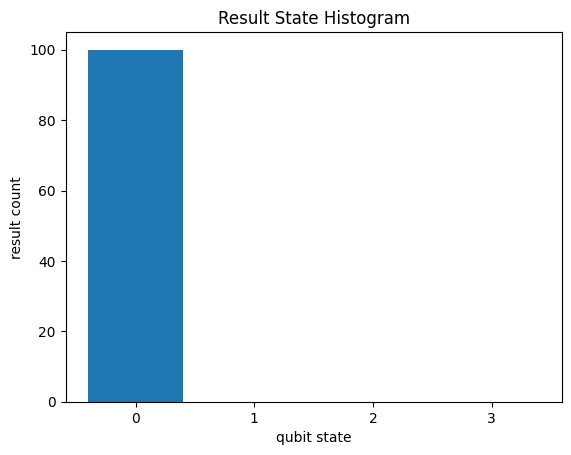

In [13]:
sim = cirq.DensityMatrixSimulator()
res = sim.run(qc1, repetitions=100)
get_counts(res)
cirq.plot_state_histogram(res)

{'11': 100}


/home/cdac/anaconda3/envs/cirq/lib/python3.10/site-packages/cirq/vis/state_histogram.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

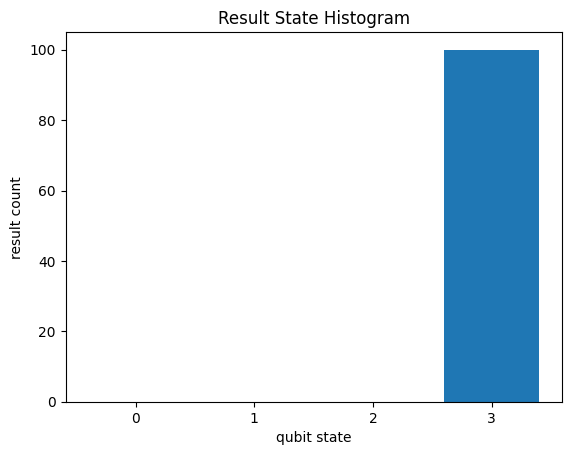

In [14]:
sim = cirq.DensityMatrixSimulator()
res = sim.run(qc2, repetitions=100)
get_counts(res)
cirq.plot_state_histogram(res)

In [15]:
res.params.param_dict

OrderedDict()

In [16]:
a=dict()
for i in qc1.all_operations():
    print(i)

X(q(2, 0))
H(q(0, 0))
H(q(1, 0))
H(q(2, 0))
<cirq_utils.to_gate object at 0x76a34b7e7b20>(q(0, 0), q(1, 0), q(2, 0))
H(q(0, 0))
H(q(1, 0))
X(q(2, 0))
cirq.MeasurementGate(2, cirq.MeasurementKey(name='result'), ())(q(0, 0), q(1, 0))


In [17]:
print(a)

{}


In [18]:
for key in a.keys():
    print(key.num_qubits())

In [19]:
# Function to print only custom gates
def print_custom_gates(circuit, custom_gate_class):
    for operation in circuit.all_operations():
        if isinstance(operation.gate, custom_gate_class):
            print(operation.gate)
            return operation
        elif isinstance(operation.gate, cirq.MeasurementGate):
            # Skip the measurement gate
            continue

# Print only custom gates in the circuit
ckt = print_custom_gates(qc1, cirq_utils.to_gate)

In [20]:
qc_e = ckt.gate.circ.copy()
print(qc_e)
for i in qc_e.all_operations():
    print(i)

(0, 0): ───I───

(1, 0): ───I───

(2, 0): ───I───
I(q(0, 0))
I(q(1, 0))
I(q(2, 0))


In [21]:
qce=cirq.Circuit(cirq.decompose(qc_e))
print(qce)

In [22]:
# Function to count gate occurrences
def count_gates(circuit):
    gate_counts = {}
    for operation in circuit.all_operations():
        gate = operation.gate
        if isinstance(gate,cirq.MeasurementGate)==False:
            if isinstance(gate, cirq_utils.to_gate):
                gate_name = gate.name
            else:
                gate_name = (gate)
            if gate_name in gate_counts:
                gate_counts[gate_name] += 1
            else:
                gate_counts[gate_name] = 1
    return gate_counts

count_gates(qc1)

{cirq.X: 2, cirq.H: 5, 'Uf': 1}

In [23]:
count_gates(qc1)

{cirq.X: 2, cirq.H: 5, 'Uf': 1}

In [24]:
print(qc1)

(0, 0): ───H───────Uf───H───M('result')───
                   │        │
(1, 0): ───H───────Uf───H───M─────────────
                   │
(2, 0): ───X───H───Uf───X─────────────────


In [25]:
qc2=cirq.Circuit(cirq.decompose(qc1))
print(qc2)

(0, 0): ───Y^0.5───X───────Y^0.5───X───M('result')───
                                       │
(1, 0): ───Y^0.5───X───────Y^0.5───X───M─────────────

(2, 0): ───X───────Y^0.5───X───────X─────────────────


In [26]:
# Define the target gateset with proper gate instances
target_gateset = cirq.Gateset(
    cirq.rx(0),  # You can specify a parameter if you want, here 0 is used as a placeholder
    cirq.ry(0),
    cirq.rz(0),
    cirq.CNOT,
    unroll_circuit_op=False  # Keep this as False if you don't want to unroll `cirq.CircuitOperation`
)

# Optimize the circuit for the target gateset
optimized_circuit = cirq.optimize_for_target_gateset(
    qc2,
    gateset=cirq.CZTargetGateset()#,
    #context=cirq.TransformerContext(deep=True)  # Use deep context to ensure full optimization
)
print(optimized_circuit)

(0, 0): ───────────────────────────M('result')───
                                   │
(1, 0): ───────────────────────────M─────────────

(2, 0): ───PhXZ(a=0.5,x=0.5,z=1)─────────────────


In [27]:
cirq.Result.data

In [28]:
print(qc1)

(0, 0): ───H───────Uf───H───M('result')───
                   │        │
(1, 0): ───H───────Uf───H───M─────────────
                   │
(2, 0): ───X───H───Uf───X─────────────────


In [29]:
counts_dict =dict()
temp_dict =dict()
def count_operations(qc,key):
    if key==None:
        temp_dict.update(count_gates(qc))
    else:
        counts_dict[str(key)] = count_gates(qc)
    for i in qc.all_operations():
        if isinstance(i.gate, cirq_utils.to_gate):
            qc_1 = i.gate.circ.copy()
            count_operations(qc_1,i.gate.name)

count_operations(qc1,None)

In [30]:
counts_dict

{'Uf': {cirq.I: 3}}

In [31]:
temp_dict

{cirq.X: 2, cirq.H: 5, 'Uf': 1}

In [32]:
def update_counts(gates,custom_gates):
    operations = {}
    for key, value in gates.items():
        operations[key] = value
    for key, value in custom_gates.items():
        if key in operations:
            operations[key] += value
        else:
            operations[key] = value       
    return operations

def get_gate_counts(gates,custom_gate_defs):
    result = gates.copy()
    # Iterate over the gate counts in the quantum circuit
    for gate, count in gates.items():
        if gate in custom_gate_defs:
            custom_gate_ops = custom_gate_defs[gate]
            # Multiply custom gate operations by the count of the custom gate in the circuit
            for _ in range(count):
                result = update_counts(result, custom_gate_ops)
            # Remove the custom gate entry as we have expanded it
            del result[gate]
    return result

In [33]:
res=get_gate_counts(temp_dict,counts_dict)

In [34]:
print(res)

{cirq.X: 2, cirq.H: 5, cirq.I: 3}


In [35]:
for i in qc1.all_operations():
    print(i)
    if isinstance(i.gate, cirq.MeasurementGate):
        print(i.gate.name)

X(q(2, 0))
H(q(0, 0))
H(q(1, 0))
H(q(2, 0))
<cirq_utils.to_gate object at 0x76a34b7e7b20>(q(0, 0), q(1, 0), q(2, 0))
H(q(0, 0))
H(q(1, 0))
X(q(2, 0))
cirq.MeasurementGate(2, cirq.MeasurementKey(name='result'), ())(q(0, 0), q(1, 0))


AttributeError: 'MeasurementGate' object has no attribute 'name'

In [ ]:
for k,v in temp_dict.items():
    print(type(k))

In [ ]:
actual = count_gates(qc1)
print(actual)

In [ ]:
for k,v in actual.items():
    if isinstance(k,cirq.Gate)==False:
        print(k)

In [ ]:
n1q=0
n2q=0
for k,v in res.items():
    if (k.num_qubits())>1:
        n2q+=v
    else:
        n1q+=v

In [ ]:
n1q 

In [ ]:
x=count_operations(qc1,None)
print(x)

In [ ]:
counts_dict

In [ ]:
temp_dict

In [ ]:
for i in temp_dict.keys():
    if isinstance(i,cirq.Gate)==False:
        print(i)

In [ ]:
qc1

In [ ]:
qc1.moments

In [ ]:
qcx = qc1.copy()

In [ ]:
qcx = qcx.with_noise(cirq.amplitude_damp(gamma=0.01))

In [ ]:
qcx.moments

In [ ]:
qcx = qcx.with_noise(cirq.phase_flip(p=0.01))
qcx.moments

In [133]:
qc1

(0, 0): ───H───────Uf───H───M('result')───
                   │        │
(1, 0): ───H───────Uf───H───M─────────────
                   │
(2, 0): ───X───H───Uf───X─────────────────

In [134]:
for i in qc1.all_operations():
    print(i.gate)

X
H
H
H
H
H
X
cirq.MeasurementGate(2, cirq.MeasurementKey(name='result'), ())


In [135]:
dict_of_qc =dict()
def circuit_traverser(qc,key=None):
    if key == None:
        key = "qc"
    dict_of_qc[key]=count_gates(qc)
    for i in qc.all_operations():
        if isinstance(i.gate,cirq_utils.to_gate):
            qc_1 = i.gate.circ.copy()
            print(qc_1)
            circuit_traverser(qc_1,i.gate.name)
            
circuit_traverser(qc1)

(0, 0): ───I───

(1, 0): ───I───

(2, 0): ───I───


In [136]:
print(dict_of_qc)

{'qc': {cirq.X: 2, cirq.H: 5, 'Uf': 1}, 'Uf': {cirq.I: 3}}


In [109]:
qc_1 

NameError: name 'qc_1' is not defined

In [131]:
import cirq
import inspect

# Function to check if an object is a gate
def is_gate(obj):
    return isinstance(obj, cirq.Gate)

# Get all attributes from the cirq module
cirq_attributes = dir(cirq)

# Filter out the gates from the attributes
standard_gates = [getattr(cirq, attr) for attr in cirq_attributes if is_gate(getattr(cirq, attr))]

# Print the list of standard gates
for gate in standard_gates:
    print(gate)


TOFFOLI
TOFFOLI
CCZ
CNOT
FREDKIN
CNOT
CZ
FREDKIN
H
I
ISWAP
ISWAP_INV
S
ISWAP**0.5
ISWAP**-0.5
SWAP
T
TOFFOLI
X
XX
Y
YY
Z
ZZ


In [102]:
for i in qc1.all_operations():
    if cirq.GateFamily(i.gate)==None:
        print(i)

    else:
        print(cirq.GateFamily(i.gate).name)

Instance GateFamily: X
Instance GateFamily: H
Instance GateFamily: H
Instance GateFamily: H
Instance GateFamily: <cirq_utils.to_gate object at 0x76a34b7e7b20>
Instance GateFamily: H
Instance GateFamily: H
Instance GateFamily: X
Instance GateFamily: cirq.MeasurementGate(2, cirq.MeasurementKey(name='result'), ())


In [99]:
cirq.Gat

TypeError: 'ABCMetaImplementAnyOneOf' object is not iterable

In [130]:
for i in qc1.all_operations():
    if isinstance(i.gate,cirq_utils.to_gate):
        qc_1 = i.gate.circ.copy()
        print(qc_1)

(0, 0): ───I───

(1, 0): ───I───

(2, 0): ───I───


In [ ]:
dict_of_qc : {'C-U^2': {'cMULTamodN': 1, cirq.FREDKIN: 2, (<cirq_utils.to_gate object at 0x79128c69d870>**-1): 1},
              'cMULTamodN': {'qft': 1, 'ccφADDmodN': 2, 'inv_qft': 1}, 'qft': {cirq.H: 3, (cirq.CZ**0.5): 2, (cirq.CZ**0.25): 1}, 
              'ccφADDmodN': {'φADD': 3, (<cirq_utils.to_gate object at 0x79128c5902e0>**-1): 1, 'inv_qft': 2, cirq.CNOT: 2, 'qft': 2, 
                             cirq.ControlledGate(sub_gate=(<cirq_utils.to_gate object at 0x79128c57fd30>**-1), num_controls=2): 1, cirq.X: 2},
'inv_qft': {cirq.H: 4, (cirq.CZ**-0.5): 3, (cirq.CZ**-0.25): 2, (cirq.CZ**-0.125): 1},
'C-U^4': {'cMULTamodN': 1, cirq.FREDKIN: 2, (<cirq_utils.to_gate object at 0x79128c5199f0>**-1): 1}, 
'C-U^16': {'cMULTamodN': 1, cirq.FREDKIN: 2, (<cirq_utils.to_gate object at 0x79128c569a80>**-1): 1},
'C-U^256': {'cMULTamodN': 1, cirq.FREDKIN: 2, (<cirq_utils.to_gate object at 0x79128c5b9b40>**-1): 1}}

In [ ]:
final operations = {cirq.H: {'count': 148, 'num_qubits': 1}, 
                    cirq.X: {'count': 17, 'num_qubits': 1},
                    cirq.FREDKIN: {'count': 8, 'num_qubits': 3}, 
                    (<cirq_utils.to_gate object at 0x79128c69d870>**-1): {'count': 1, 'num_qubits': 7}, 
                    (cirq.CZ**0.5): {'count': 40, 'num_qubits': 2}, (cirq.CZ**0.25): {'count': 20, 'num_qubits': 2}, 
                    (<cirq_utils.to_gate object at 0x79128c5902e0>**-1): {'count': 8, 'num_qubits': 3}, 
                    cirq.CNOT: {'count': 16, 'num_qubits': 2}, 
                    cirq.ControlledGate(sub_gate=(<cirq_utils.to_gate object at 0x79128c57fd30>**-1), num_controls=2): {'count': 8, 'num_qubits': 5}, 
(cirq.CZ**-0.5): {'count': 63, 'num_qubits': 2}, 
(cirq.CZ**-0.25): {'count': 42, 'num_qubits': 2}, 
(cirq.CZ**-0.125): {'count': 21, 'num_qubits': 2}, 
(<cirq_utils.to_gate object at 0x79128c5199f0>**-1): {'count': 1, 'num_qubits': 7}, 
(<cirq_utils.to_gate object at 0x79128c569a80>**-1): {'count': 1, 'num_qubits': 7}, 
(<cirq_utils.to_gate object at 0x79128c5b9b40>**-1): {'count': 1, 'num_qubits': 7}}